# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


## The basic idea is that the CNNs learn things in a hierarchical manner

Thus, if we have a great classifier that can classify 10k objects with 99% accuracy, it must have great primary layers that learn the basic features perfectly. 

So we can use the primary layers for other things, like classifying 11k objects !


## Let's talk about some pretrained models

- VGG16, VGG19 having 16 and 19 layers respectively 

- ResNet is larger than VGG, with different branches that learn something different; ResNet50, ResNet151, are variations

- Inception has multiple convolutions in parallel branches, different sizes of filters are tried and then their results are appended 


## Rule of Thumb

Computations take time, we must work around them. As a rule of thumb, if you're using data augmentation, put CNN computations inside the training loop.


In [0]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import sys, os


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16 as pretrained, preprocess_input


## Let's import the dataset


In [6]:
!wget --passive-ftp --prefer-family=ipv4 https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz

--2020-05-25 07:07:25--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341553947 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.73M  36.0MB/s    in 9.7s    

2020-05-25 07:07:35 (33.6 MB/s) - ‘imagenette2-320.tgz’ saved [341553947/341553947]



In [7]:
!ls

imagenette2-320.tgz  sample_data


In [0]:
!tar -xzvf imagenette2-320.tgz

In [19]:
!ls imagenette2-320/train

n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257


In [12]:
!ls imagenette2-320/val

n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257


In [0]:
path = 'imagenette2-320/train'
path_val = 'imagenette2-320/val'

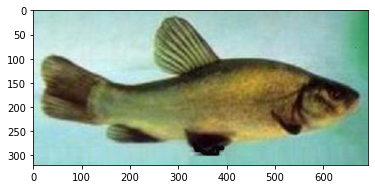

In [38]:
plt.imshow(image.load_img(path + '/n01440764/n01440764_1514.JPEG'))
plt.show()

In [0]:
IMAGE_SIZE = [200,200]
train_images = glob(path + '/*/*.JPEG')
validation_images = glob(path_val + '/*/*.JPEG')

In [0]:
# Number of classes 
classes = glob(path + '/*')

In [42]:
classes

['imagenette2-320/train/n03028079',
 'imagenette2-320/train/n03445777',
 'imagenette2-320/train/n02979186',
 'imagenette2-320/train/n02102040',
 'imagenette2-320/train/n03417042',
 'imagenette2-320/train/n03394916',
 'imagenette2-320/train/n01440764',
 'imagenette2-320/train/n03888257',
 'imagenette2-320/train/n03425413',
 'imagenette2-320/train/n03000684']

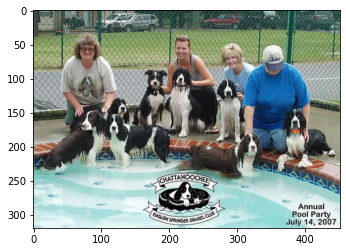

In [25]:
plt.imshow(image.load_img(np.random.choice(train_images)))
plt.show()

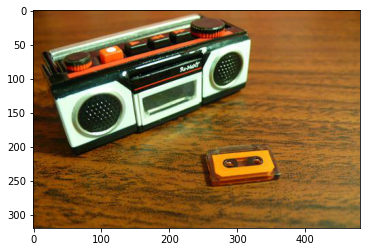

In [29]:
plt.imshow(image.load_img(np.random.choice(validation_images)))
plt.show()

In [30]:
C = 3
pretrained_model = pretrained(input_shape = IMAGE_SIZE + [C],
                              weights = 'imagenet',
                              include_top = False)
pretrained_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
Y = len(classes)
h_layer = Flatten()(pretrained_model.output)
o_layer = Dense(Y, activation= 'softmax')(h_layer)

In [0]:
model = Model(pretrained_model.input, o_layer)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
gen_object = ImageDataGenerator(rotation_range = 10,
                                width_shift_range = 0.1, 
                                height_shift_range = 0.1, 
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                preprocessing_function = preprocess_input)

In [43]:
len(train_images)

9469

In [0]:
batch_size = 254

In [46]:
train_generator = gen_object.flow_from_directory(path, shuffle=True, target_size=IMAGE_SIZE, batch_size=batch_size)
validation_generator = gen_object.flow_from_directory(path_val, target_size=IMAGE_SIZE, batch_size=batch_size)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy'])

In [48]:
report = model.fit_generator(train_generator, 
                             validation_data=validation_generator, 
                             epochs=10,
                             steps_per_epoch = int(np.ceil(len(train_images)/batch_size)),
                             validation_steps = int(np.ceil(len(validation_images)/batch_size)))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
38/38 [==============================] - 147s 4s/step - loss: 3.5040 - accuracy: 0.8501 - val_loss: 1.6289 - val_accuracy: 0.9256
Epoch 2/10
38/38 [==============================] - 148s 4s/step - loss: 0.8479 - accuracy: 0.9550 - val_loss: 1.3086 - val_accuracy: 0.9391
Epoch 3/10
38/38 [==============================] - 149s 4s/step - loss: 0.5958 - accuracy: 0.9651 - val_loss: 1.2870 - val_accuracy: 0.9399
Epoch 4/10
38/38 [==============================] - 147s 4s/step - loss: 0.5794 - accuracy: 0.9657 - val_loss: 1.5968 - val_accuracy: 0.9355
Epoch 5/10
38/38 [==============================] - 144s 4s/step - loss: 0.4447 - accuracy: 0.9716 - val_loss: 1.4917 - val_accuracy: 0.9422
Epoch 6/10
38/38 [==============================] - 147s 4s/step - loss: 0.3050 - accuracy: 0.9797 - val_loss: 1.4039 - val_accuracy: 0.9411
Epoch 7/10
38/38 [==============================] - 144s 4s/step - loss: 0.342

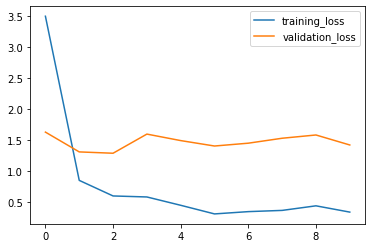

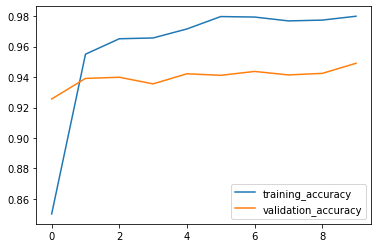

In [50]:
  plt.plot(report.history['loss'], label = 'training_loss')
  plt.plot(report.history['val_loss'], label = 'validation_loss')
  plt.legend()
  plt.show()
  plt.plot(report.history['accuracy'], label = 'training_accuracy')
  plt.plot(report.history['val_accuracy'], label = 'validation_accuracy')
  plt.legend()
  plt.show()